In [ ]:
!pip install -q pycocoevalcap nltk rouge-score pyspellchecker

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 17.2 MB/s eta 0:00:00


In [ ]:
import os
import json
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from tqdm import tqdm
import numpy as np

# Métricas
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Corrector ortográfico
from spellchecker import SpellChecker

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [ ]:
!unzip /content/TESTING.zip

Archive:  /content/TESTING.zip
   creating: TESTING/
  inflating: TESTING/vaca_1.jpg      
  inflating: TESTING/vaca_1.txt      
  inflating: TESTING/vaca_10.jpg     
  inflating: TESTING/vaca_10.txt     
  inflating: TESTING/vaca_11.jpg     
  inflating: TESTING/vaca_11.txt     
  inflating: TESTING/vaca_12.jpg     
  inflating: TESTING/vaca_12.txt     
  inflating: TESTING/vaca_13.jpg     
  inflating: TESTING/vaca_13.txt     
  inflating: TESTING/vaca_14.jpg     
  inflating: TESTING/vaca_14.txt     
  inflating: TESTING/vaca_15.jpg     
  inflating: TESTING/vaca_15.txt     
  inflating: TESTING/vaca_16.jpg     
  inflating: TESTING/vaca_16.txt     
  inflating: TESTING/vaca_17.jpg     
  inflating: TESTING/vaca_17.txt     
  inflating: TESTING/vaca_18.jpg     
  inflating: TESTING/vaca_18.txt     
  inflating: TESTING/vaca_19.jpg     
  inflating: TESTING/vaca_19.txt     
  inflating: TESTING/vaca_2.jpg      
  inflating: TESTING/vaca_2.txt      
  inflating: TESTING/vaca_20.jpg   

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# 📁 Ruta raíz del dataset (nivel más alto)
root_dir = "/content/TESTING"

# 📄 Ruta del CSV de salida
output_csv_path = "/content/csv/captions.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

# Extensiones válidas
IMG_EXTS = (".jpg", ".jpeg", ".png")

csv_data = []

# 🔁 Recorrido recursivo por TODAS las subcarpetas
all_files = []
for dirpath, dirnames, filenames in os.walk(root_dir):
    for fn in filenames:
        all_files.append((dirpath, fn))

for dirpath, fn in tqdm(all_files, desc="Buscando imágenes"):
    if not fn.lower().endswith(IMG_EXTS):
        continue

    img_path = os.path.join(dirpath, fn)

    # txt con el mismo nombre base
    base = os.path.splitext(fn)[0]
    txt_path = os.path.join(dirpath, base + ".txt")

    if not os.path.exists(txt_path):
        # Si quieres, puedes saltar silenciosamente sin print
        print(f"⚠️ Falta TXT: {os.path.relpath(img_path, root_dir)}")
        continue

    # leer caption
    with open(txt_path, "r", encoding="utf-8") as f:
        caption = f.read().strip()

    # ruta relativa (incluye TODA la ruta interna)
    rel_img = os.path.relpath(img_path, root_dir)
    csv_data.append((rel_img, caption))

# 💾 Guardar CSV
df = pd.DataFrame(csv_data, columns=["image", "caption"])
df.to_csv(output_csv_path, index=False, encoding="utf-8")

print(f"✅ CSV generado: {output_csv_path}")
print(f"✅ Filas: {len(df)}")


Buscando imágenes: 100%|██████████| 44/44 [00:00<00:00, 35696.20it/s]

✅ CSV generado: /content/csv/captions.csv
✅ Filas: 22


In [ ]:
class BlipEspanol:
    """
    Post-procesador ortográfico con diccionario léxico manual
    Corrige tildes y eñes sin cambiar plurales ni conjugaciones
    """
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = next(model.parameters()).device

        # Diccionario manual de correcciones (SINCRONIZADO CON api/blip/diccionario_es.py)
        self.correcciones_manuales = {
            # Artículos y pronombres
            "mi": "mí",
            "tu": "tú",
            "el": "él",
            "si": "sí",
            "te": "té",
            "se": "sé",
            "mas": "más",
            "solo": "sólo",
            
            # Verbos comunes
            "esta": "está",
            "estas": "estás",
            "estan": "están",
            "cepillandose": "cepillándose",
            "lavandose": "lavándose",
            "peinandose": "peinándose",
            
            # Palabras con ñ
            "nino": "niño",
            "nina": "niña",
            "ninos": "niños",
            "ninas": "niñas",
            "anos": "años",
            "espanol": "español",
            "espanola": "española",
            "espanoles": "españoles",
            "espanolas": "españolas",
            "manana": "mañana",
            "montana": "montaña",
            "montanas": "montañas",
            "sueno": "sueño",
            "suenos": "sueños",
            "pequeno": "pequeño",
            "pequena": "pequeña",
            "pequenos": "pequeños",
            "pequenas": "pequeñas",
            "bano": "baño",
            "banos": "baños",
            
            # Interrogativos y exclamativos
            "que": "qué",
            "quien": "quién",
            "quienes": "quiénes",
            "cual": "cuál",
            "cuales": "cuáles",
            "cuando": "cuándo",
            "cuanto": "cuánto",
            "cuanta": "cuánta",
            "cuantos": "cuántos",
            "cuantas": "cuántas",
            "donde": "dónde",
            "como": "cómo",
            
            # Palabras comunes con tilde
            "acion": "acción",
            "alimentacion": "alimentación",
            "atencion": "atención",
            "aqui": "aquí",
            "alla": "allá",
            "arbol": "árbol",
            "arboles": "árboles",
            "asi": "así",
            "basica": "básica",
            "basico": "básico",
            "cafe": "café",
            "camion": "camión",
            "camara": "cámara",
            "caracteristico": "característico",
            "caracteristica": "característica",
            "climaticos": "climáticos",
            "climatico": "climático",
            "cria": "cría",
            "crias": "crías",
            "crisalida": "crisálida",
            "despues": "después",
            "dificil": "difícil",
            "dioxido": "dióxido",
            "educacion": "educación",
            "energias": "energías",
            "esofago": "esófago",
            "estomago": "estómago",
            "facil": "fácil",
            "geografico": "geográfico",
            "geografica": "geográfica",
            "geologicos": "geológicos",
            "geologico": "geológico",
            "gotica": "gótica",
            "gotico": "gótico",
            "historico": "histórico",
            "historica": "histórica",
            "jabon": "jabón",
            "jardin": "jardín",
            "jovenes": "jóvenes",
            "lapiz": "lápiz",
            "mama": "mamá",
            "medica": "médica",
            "medico": "médico",
            "movil": "móvil",
            "musica": "música",
            "nacion": "nación",
            "oxigeno": "oxígeno",
            "pajaro": "pájaro",
            "pajaros": "pájaros",
            "razon": "razón",
            "region": "región",
            "tambien": "también",
            "telefono": "teléfono",
            "television": "televisión",
            "ultimo": "último",
            "ultima": "última",
            "ultimos": "últimos",
            "ultimas": "últimas",
            
            # Lugares
            "habitacion": "habitación",
            "salon": "salón",
        }

    @classmethod
    def from_pretrained(cls, model_path, device="cpu"):
        """Cargar modelo desde un path"""
        processor = BlipProcessor.from_pretrained(model_path)
        model = BlipForConditionalGeneration.from_pretrained(model_path).to(device)
        return cls(model, processor)

    def _corregir_texto(self, texto):
        """
        Corrector con diccionario manual
        SOLO agrega tildes/eñes, NO cambia estructura
        """
        palabras = texto.split()
        palabras_corregidas = []

        for palabra_original in palabras:
            # Separar puntuación
            puntuacion_final = ""
            palabra = palabra_original

            if palabra and palabra[-1] in ".;,;:!?":
                puntuacion_final = palabra[-1]
                palabra = palabra[:-1]

            palabra_lower = palabra.lower()

            # PASO 1: Verificar diccionario manual
            if palabra_lower in self.correcciones_manuales:
                palabra_corregida = self.correcciones_manuales[palabra_lower]

                # Preservar mayúscula inicial
                if palabra and palabra[0].isupper():
                    palabra_corregida = palabra_corregida.capitalize()

                palabra_corregida += puntuacion_final
                palabras_corregidas.append(palabra_corregida)
            else:
                # NO está en diccionario → mantener original
                palabras_corregidas.append(palabra_original)

        return " ".join(palabras_corregidas)

    def predict(self, image, max_new_tokens=100, num_beams=3, apply_correction=True, **kwargs):
        """
        Generar caption para una imagen

        Args:
            image: PIL Image o path a imagen
            max_new_tokens: tokens máximos a generar
            num_beams: beams para beam search
            apply_correction: si aplicar corrección ortográfica
        """
        # Cargar imagen si es un path
        if isinstance(image, (str, Path)):
            image = Image.open(image).convert("RGB")

        # Procesar imagen
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        # Generar caption
        with torch.no_grad():
            out = self.model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_beams=num_beams,
                **kwargs
            )

        # Decodificar
        caption = self.processor.decode(out[0], skip_special_tokens=True)

        # IMPORTANTE: Primera letra siempre en mayúscula (como en producción)
        if caption:
            caption = caption[0].upper() + caption[1:] if len(caption) > 1 else caption.upper()

        # Aplicar corrección si está habilitado
        if apply_correction:
            caption = self._corregir_texto(caption)

        return caption

    def to(self, device):
        """Mover modelo a dispositivo"""
        self.model = self.model.to(device)
        self.device = device
        return self

    def eval(self):
        """Poner modelo en modo evaluación"""
        self.model.eval()
        return self

✅ Clase BlipEspanol definida


In [ ]:
def calcular_metricas_coco(gts, res):
    """Calcular métricas usando pycocoevalcap"""
    metricas = {}

    # BLEU (1-4)
    scorer = Bleu(4)
    score, scores = scorer.compute_score(gts, res)
    metricas['Bleu_1'] = score[0]
    metricas['Bleu_2'] = score[1]
    metricas['Bleu_3'] = score[2]
    metricas['Bleu_4'] = score[3]
    print(f"   • BLEU-1: {score[0]:.4f}")
    print(f"   • BLEU-2: {score[1]:.4f}")
    print(f"   • BLEU-3: {score[2]:.4f}")
    print(f"   • BLEU-4: {score[3]:.4f}")

    # METEOR
    scorer = Meteor()
    score, scores = scorer.compute_score(gts, res)
    metricas['METEOR'] = score
    print(f"   • METEOR: {score:.4f}")

    # ROUGE-L
    scorer = Rouge()
    score, scores = scorer.compute_score(gts, res)
    metricas['ROUGE_L'] = score
    print(f"   • ROUGE-L: {score:.4f}")

    # CIDEr
    scorer = Cider()
    score, scores = scorer.compute_score(gts, res)
    metricas['CIDEr'] = score
    print(f"   • CIDEr: {score:.4f}")

    # SPICE (puede tardar más)
    try:
        scorer = Spice()
        score, scores = scorer.compute_score(gts, res)
        metricas['SPICE'] = score
        print(f"   • SPICE: {score:.4f}")
    except Exception as e:
        print(f"   ⚠️ SPICE no disponible: {e}")
        metricas['SPICE'] = None

    return metricas


def calcular_wer(referencia, hipotesis):
    """Calcular Word Error Rate"""
    ref_words = referencia.split()
    hyp_words = hipotesis.split()

    # Distancia de Levenshtein a nivel de palabras
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))

    for i in range(len(ref_words) + 1):
        d[i][0] = i
    for j in range(len(hyp_words) + 1):
        d[0][j] = j

    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(d[i-1][j], d[i][j-1], d[i-1][j-1]) + 1

    return d[len(ref_words)][len(hyp_words)] / len(ref_words) if ref_words else 0


def calcular_metricas_adicionales(referencias, predicciones):
    """Calcular métricas adicionales personalizadas"""
    metricas = {}

    # Longitud promedio
    len_ref = np.mean([len(ref.split()) for ref in referencias])
    len_pred = np.mean([len(pred.split()) for pred in predicciones])
    metricas['longitud_promedio_referencia'] = float(len_ref)
    metricas['longitud_promedio_prediccion'] = float(len_pred)

    # Diversidad de vocabulario
    vocab_ref = set(" ".join(referencias).split())
    vocab_pred = set(" ".join(predicciones).split())
    metricas['vocabulario_unico_referencia'] = len(vocab_ref)
    metricas['vocabulario_unico_prediccion'] = len(vocab_pred)
    metricas['cobertura_vocabulario'] = len(vocab_pred & vocab_ref) / len(vocab_ref) if vocab_ref else 0

    # Word Error Rate (WER) aproximado
    wer_scores = []
    for ref, pred in zip(referencias, predicciones):
        wer = calcular_wer(ref, pred)
        wer_scores.append(wer)
    metricas['WER_promedio'] = float(np.mean(wer_scores))

    return metricas


def imprimir_resumen_metricas(resultados):
    """Imprimir resumen bonito de las métricas"""
    print("\n" + "="*70)
    print("📊 RESUMEN DE EVALUACIÓN")
    print("="*70)

    print(f"\n🔹 Modelo: {resultados['modelo']}")
    print(f"🔹 Muestras evaluadas: {resultados['num_muestras']}")

    print("\n" + "-"*70)
    print("SIN POST-PROCESADOR:")
    print("-"*70)
    sin = resultados['sin_post_procesador']
    print(f"   BLEU-1:  {sin['Bleu_1']:.4f}")
    print(f"   BLEU-4:  {sin['Bleu_4']:.4f}")
    print(f"   METEOR:  {sin['METEOR']:.4f}")
    print(f"   ROUGE-L: {sin['ROUGE_L']:.4f}")
    print(f"   CIDEr:   {sin['CIDEr']:.4f}")
    print(f"   WER:     {sin['WER_promedio']:.4f}")

    print("\n" + "-"*70)
    print("CON POST-PROCESADOR:")
    print("-"*70)
    con = resultados['con_post_procesador']
    print(f"   BLEU-1:  {con['Bleu_1']:.4f}")
    print(f"   BLEU-4:  {con['Bleu_4']:.4f}")
    print(f"   METEOR:  {con['METEOR']:.4f}")
    print(f"   ROUGE-L: {con['ROUGE_L']:.4f}")
    print(f"   CIDEr:   {con['CIDEr']:.4f}")
    print(f"   WER:     {con['WER_promedio']:.4f}")

    print("\n" + "-"*70)
    print("MEJORA PORCENTUAL:")
    print("-"*70)
    mejora = resultados['mejora_porcentual']
    for metrica, valor in mejora.items():
        simbolo = "📈" if valor > 0 else "📉" if valor < 0 else "➡️"
        print(f"   {simbolo} {metrica}: {valor:+.2f}%")

    print("\n" + "-"*70)
    print("EJEMPLOS DE PREDICCIONES:")
    print("-"*70)
    for i, ejemplo in enumerate(resultados['ejemplos_comparacion'][:3], 1):
        print(f"\n{i}. {ejemplo['imagen']}")
        print(f"   📖 Referencia:     {ejemplo['referencia']}")
        print(f"   ❌ Sin corrector:  {ejemplo['sin_corrector']}")
        print(f"   ✅ Con corrector:  {ejemplo['con_corrector']}")

    print("\n" + "="*70)

print("✅ Funciones auxiliares definidas")

✅ Funciones auxiliares definidas


In [ ]:
def evaluar_modelo_completo(
    model_path,
    test_csv_path,
    image_base_path,
    output_results_path="resultados_evaluacion.json",
    device="cpu"
):
    """
    Evalúa el modelo BLIP con y sin post-procesador

    Args:
        model_path: Path al modelo entrenado
        test_csv_path: Path al CSV con datos de test (columnas: image, caption)
        image_base_path: Path base donde están las imágenes
        output_results_path: Path para guardar resultados
        device: cuda o cpu
    """

    print("="*70)
    print("🎓 EVALUACIÓN COMPLETA DEL MODELO BLIP PARA TESIS")
    print("="*70)

    # 1. Cargar dataset de test
    print("\n📂 Cargando dataset de test...")
    df_test = pd.read_csv(test_csv_path, encoding='utf-8')
    print(f"   • Total de muestras: {len(df_test)}")

    # 2. Cargar modelo
    print(f"\n🤖 Cargando modelo desde: {model_path}")
    modelo_con_corrector = BlipEspanol.from_pretrained(model_path, device=device)
    modelo_con_corrector.eval()
    print(f"   • Modelo cargado en: {device}")

    # 3. Generar predicciones SIN corrector
    print("\n🔍 Generando predicciones SIN post-procesador...")
    predicciones_sin_corrector = []

    for idx, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Sin corrector"):
        img_path = Path(image_base_path) / row['image']
        try:
            caption = modelo_con_corrector.predict(
                img_path,
                apply_correction=False  # SIN CORRECCIÓN
            )
            predicciones_sin_corrector.append(caption)
        except Exception as e:
            print(f"   ⚠️ Error en {img_path}: {e}")
            predicciones_sin_corrector.append("")

    # 4. Generar predicciones CON corrector
    print("\n✨ Generando predicciones CON post-procesador...")
    predicciones_con_corrector = []

    for idx, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Con corrector"):
        img_path = Path(image_base_path) / row['image']
        try:
            caption = modelo_con_corrector.predict(
                img_path,
                apply_correction=True  # CON CORRECCIÓN
            )
            predicciones_con_corrector.append(caption)
        except Exception as e:
            print(f"   ⚠️ Error en {img_path}: {e}")
            predicciones_con_corrector.append("")

    # 5. Preparar referencias y predicciones para pycocoevalcap
    print("\n📊 Calculando métricas...")

    # Formato requerido: {id: [caption1, caption2, ...]}
    gts = {}  # ground truths (referencias)
    res_sin = {}  # resultados sin corrector
    res_con = {}  # resultados con corrector

    for idx, row in df_test.iterrows():
        gts[idx] = [row['caption']]
        res_sin[idx] = [predicciones_sin_corrector[idx]]
        res_con[idx] = [predicciones_con_corrector[idx]]

    # 6. Calcular métricas SIN corrector
    print("\n📈 Métricas SIN post-procesador:")
    metricas_sin = calcular_metricas_coco(gts, res_sin)

    # 7. Calcular métricas CON corrector
    print("\n📈 Métricas CON post-procesador:")
    metricas_con = calcular_metricas_coco(gts, res_con)

    # 8. Calcular métricas adicionales
    print("\n📊 Métricas adicionales...")
    metricas_adicionales_sin = calcular_metricas_adicionales(
        df_test['caption'].tolist(),
        predicciones_sin_corrector
    )
    metricas_adicionales_con = calcular_metricas_adicionales(
        df_test['caption'].tolist(),
        predicciones_con_corrector
    )

    # 9. Combinar todos los resultados
    resultados = {
        "modelo": str(model_path),
        "dataset_test": str(test_csv_path),
        "num_muestras": len(df_test),
        "device": device,

        "sin_post_procesador": {
            **metricas_sin,
            **metricas_adicionales_sin
        },

        "con_post_procesador": {
            **metricas_con,
            **metricas_adicionales_con
        },

        "mejora_porcentual": {
            "BLEU-1": ((metricas_con['Bleu_1'] - metricas_sin['Bleu_1']) / metricas_sin['Bleu_1'] * 100) if metricas_sin['Bleu_1'] > 0 else 0,
            "BLEU-4": ((metricas_con['Bleu_4'] - metricas_sin['Bleu_4']) / metricas_sin['Bleu_4'] * 100) if metricas_sin['Bleu_4'] > 0 else 0,
            "METEOR": ((metricas_con['METEOR'] - metricas_sin['METEOR']) / metricas_sin['METEOR'] * 100) if metricas_sin['METEOR'] > 0 else 0,
            "ROUGE_L": ((metricas_con['ROUGE_L'] - metricas_sin['ROUGE_L']) / metricas_sin['ROUGE_L'] * 100) if metricas_sin['ROUGE_L'] > 0 else 0,
            "CIDEr": ((metricas_con['CIDEr'] - metricas_sin['CIDEr']) / metricas_sin['CIDEr'] * 100) if metricas_sin['CIDEr'] > 0 else 0,
        },

        "ejemplos_comparacion": [
            {
                "imagen": df_test.iloc[i]['image'],
                "referencia": df_test.iloc[i]['caption'],
                "sin_corrector": predicciones_sin_corrector[i],
                "con_corrector": predicciones_con_corrector[i]
            }
            for i in range(min(10, len(df_test)))  # Primeros 10 ejemplos
        ]
    }

    # 10. Guardar resultados
    with open(output_results_path, 'w', encoding='utf-8') as f:
        json.dump(resultados, f, indent=2, ensure_ascii=False)

    print(f"\n💾 Resultados guardados en: {output_results_path}")

    # 11. Imprimir resumen
    imprimir_resumen_metricas(resultados)

    return resultados

print("✅ Función principal de evaluación definida")

✅ Función principal de evaluación definida


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_resultados(json_path):
    """Crear gráficas para la tesis"""

    # Cargar resultados
    with open(json_path, 'r', encoding='utf-8') as f:
        resultados = json.load(f)

    # Extraer métricas
    sin = resultados['sin_post_procesador']
    con = resultados['con_post_procesador']

    metricas_principales = ['Bleu_1', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr']
    valores_sin = [sin[m] for m in metricas_principales]
    valores_con = [con[m] for m in metricas_principales]

    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfica 1: Comparación de métricas
    x = np.arange(len(metricas_principales))
    width = 0.35

    axes[0].bar(x - width/2, valores_sin, width, label='Sin Post-procesador', alpha=0.8)
    axes[0].bar(x + width/2, valores_con, width, label='Con Post-procesador', alpha=0.8)
    axes[0].set_xlabel('Métricas')
    axes[0].set_ylabel('Puntuación')
    axes[0].set_title('Comparación de Métricas de Evaluación')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metricas_principales, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Gráfica 2: Mejora porcentual
    mejoras = resultados['mejora_porcentual']
    metricas_mejora = list(mejoras.keys())
    valores_mejora = list(mejoras.values())

    colores = ['green' if v > 0 else 'red' for v in valores_mejora]
    axes[1].barh(metricas_mejora, valores_mejora, color=colores, alpha=0.7)
    axes[1].set_xlabel('Mejora (%)')
    axes[1].set_title('Mejora Porcentual con Post-procesador')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('metricas_evaluacion.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Gráficas guardadas en: metricas_evaluacion.png")

    # Imprimir tabla para LaTeX
    print("\n📋 TABLA PARA LATEX:")
    print("\\begin{table}[h]")
    print("\\centering")
    print("\\begin{tabular}{|l|c|c|c|}")
    print("\\hline")
    print("\\textbf{Métrica} & \\textbf{Sin Post-proc.} & \\textbf{Con Post-proc.} & \\textbf{Mejora (\\%)} \\\\")
    print("\\hline")
    for metrica in metricas_principales:
        mejora_key = metrica.replace('_', '-')
        mejora = resultados['mejora_porcentual'].get(mejora_key, 0)
        print(f"{metrica.replace('_', '-')} & {sin[metrica]:.4f} & {con[metrica]:.4f} & {mejora:+.2f}\\% \\\\")
    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Comparación de métricas con y sin post-procesamiento ortográfico}")
    print("\\label{tab:metricas_comparacion}")
    print("\\end{table}")

print("✅ Función de visualización definida")

✅ Función de visualización definida


In [ ]:
# ============================================
# 🚀 CONFIGURACIÓN - AJUSTA ESTOS PATHS
# ============================================

MODEL_PATH = Path("/content/drive/MyDrive/bliputf-esp-last2")
TEST_CSV = "/content/csv/captions.csv"  # Tu CSV de test con columnas: image, caption
IMAGE_BASE_PATH = "/content/TESTING"  # Carpeta base de imágenes
OUTPUT_JSON = "resultados_evaluacion_blip5.json"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("📋 CONFIGURACIÓN:")
print(f"   • Modelo: {MODEL_PATH}")
print(f"   • Test CSV: {TEST_CSV}")
print(f"   • Imágenes: {IMAGE_BASE_PATH}")
print(f"   • Dispositivo: {DEVICE}")

📋 CONFIGURACIÓN:
   • Modelo: /content/drive/MyDrive/bliputf-esp-last2
   • Test CSV: /content/csv/captions.csv
   • Imágenes: /content/TESTING
   • Dispositivo: cuda


In [ ]:
# ============================================
# 🚀 EJECUTAR EVALUACIÓN COMPLETA
# ============================================

resultados = evaluar_modelo_completo(
    model_path=MODEL_PATH,
    test_csv_path=TEST_CSV,
    image_base_path=IMAGE_BASE_PATH,
    output_results_path=OUTPUT_JSON,
    device=DEVICE
)

print("\n✅ Evaluación completada")
print(f"📊 Revisa el archivo: {OUTPUT_JSON}")

🎓 EVALUACIÓN COMPLETA DEL MODELO BLIP PARA TESIS

📂 Cargando dataset de test...
   • Total de muestras: 22

🤖 Cargando modelo desde: /content/drive/MyDrive/bliputf-esp-last2
   • Modelo cargado en: cuda

🔍 Generando predicciones SIN post-procesador...


Sin corrector: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]



✨ Generando predicciones CON post-procesador...


Con corrector: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]



📊 Calculando métricas...

📈 Métricas SIN post-procesador:
{'testlen': 860, 'reflen': 858, 'guess': [860, 838, 816, 794], 'correct': [722, 611, 546, 483]}
ratio: 1.0023310023298342
   • BLEU-1: 0.8395
   • BLEU-2: 0.7824
   • BLEU-3: 0.7426
   • BLEU-4: 0.7065
   • METEOR: 0.5332
   • ROUGE-L: 0.8323
   • CIDEr: 0.0000
   • SPICE: 0.8805

📈 Métricas CON post-procesador:
{'testlen': 860, 'reflen': 858, 'guess': [860, 838, 816, 794], 'correct': [743, 675, 630, 588]}
ratio: 1.0023310023298342
   • BLEU-1: 0.8640
   • BLEU-2: 0.8342
   • BLEU-3: 0.8130
   • BLEU-4: 0.7942
   • METEOR: 0.5643
   • ROUGE-L: 0.8565
   • CIDEr: 0.0000
   • SPICE: 0.9321

📊 Métricas adicionales...

💾 Resultados guardados en: resultados_evaluacion_blip5.json

📊 RESUMEN DE EVALUACIÓN

🔹 Modelo: /content/drive/MyDrive/bliputf-esp-last2
🔹 Muestras evaluadas: 22

----------------------------------------------------------------------
SIN POST-PROCESADOR:
---------------------------------------------------------------

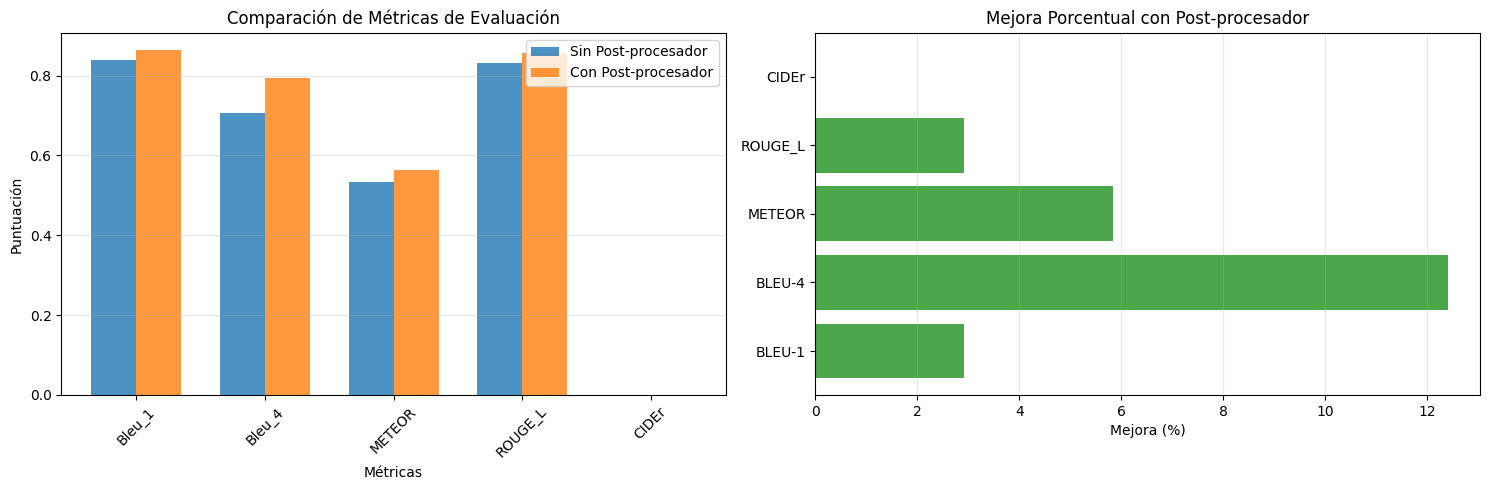

✅ Gráficas guardadas en: metricas_evaluacion.png

📋 TABLA PARA LATEX:
\begin{table}[h]
\centering
\begin{tabular}{|l|c|c|c|}
\hline
\textbf{Métrica} & \textbf{Sin Post-proc.} & \textbf{Con Post-proc.} & \textbf{Mejora (\%)} \\
\hline
Bleu-1 & 0.8395 & 0.8640 & +0.00\% \\
Bleu-4 & 0.7065 & 0.7942 & +0.00\% \\
METEOR & 0.5332 & 0.5643 & +5.84\% \\
ROUGE-L & 0.8323 & 0.8565 & +0.00\% \\
CIDEr & 0.0000 & 0.0000 & +0.00\% \\
\hline
\end{tabular}
\caption{Comparación de métricas con y sin post-procesamiento ortográfico}
\label{tab:metricas_comparacion}
\end{table}


In [ ]:
# ============================================
# 📊 VISUALIZAR RESULTADOS
# ============================================

visualizar_resultados(OUTPUT_JSON)